<a href="https://colab.research.google.com/github/MaheshKaramunge/Development-of-AI-Powered-Loan-Eligibility-Advisory-System/blob/main/Python_Task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 1. Check Python and library versions (Colab-friendly)
import sys, platform, sklearn, numpy as np, pandas as pd
import matplotlib, matplotlib.pyplot as plt
print('Python:', sys.version.split()[0])
print('Platform:', platform.platform())
print('numpy:', np.__version__)
print('pandas:', pd.__version__)
print('sklearn:', sklearn.__version__)
print('matplotlib:', matplotlib.__version__)

Python: 3.12.11
Platform: Linux-6.1.123+-x86_64-with-glibc2.35
numpy: 2.0.2
pandas: 2.2.2
sklearn: 1.6.1
matplotlib: 3.10.0


In [2]:
# 2. Core imports
import numpy as np
import pandas as pd
from pathlib import Path

# Visualization
import matplotlib.pyplot as plt

# Sklearn utilities
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, classification_report, RocCurveDisplay)
from sklearn.impute import SimpleImputer

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, IsolationForest

# Persistence
import joblib

# Random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [3]:
# 3. (Optional) Paths for real dataset if you have one
# Example: set DATA_CSV to a local path in Colab/Drive. Leave as None to use synthetic data.
DATA_CSV = None  # e.g., '/content/drive/MyDrive/CICIDS/processed_cicids.csv'

In [4]:
# 4. Generate synthetic data if no CSV is provided
def make_synthetic_netsec(n_samples=20000, attack_ratio=0.35, random_state=42):
    rng = np.random.default_rng(random_state)

    # Numeric features (simulate network-style metrics)
    duration = rng.gamma(shape=2.0, scale=2.0, size=n_samples)            # connection duration
    src_bytes = rng.lognormal(mean=7.0, sigma=1.0, size=n_samples)        # bytes from source
    dst_bytes = rng.lognormal(mean=6.5, sigma=1.1, size=n_samples)        # bytes to destination
    pkt_rate = rng.normal(loc=200, scale=60, size=n_samples).clip(0)      # packets per second
    tcp_flags = rng.poisson(lam=2.0, size=n_samples)                       # rough proxy for flags count
    failed_login = rng.binomial(1, 0.08, n_samples)                        # failed login indicator
    urgent_pkts = rng.poisson(lam=0.2, size=n_samples)                     # urgent packet count
    svc_latency = rng.normal(loc=100, scale=30, size=n_samples).clip(1)    # ms

    # Categorical: protocol, service, state
    protocols = rng.choice(['tcp', 'udp', 'icmp'], size=n_samples, p=[0.65, 0.3, 0.05])
    services = rng.choice(['http','https','dns','ssh','ftp','smtp','rdp','snmp'],
                          size=n_samples, p=[0.3,0.2,0.15,0.1,0.08,0.07,0.05,0.05])
    states = rng.choice(['S0','S1','S2','REJ','RST','SF'], size=n_samples, p=[0.15,0.25,0.1,0.1,0.1,0.3])

    # Base label
    y = (rng.random(n_samples) < attack_ratio).astype(int)

    # Inject signal: distributions drift for attacks
    duration += y * rng.gamma(3.0, 3.0, n_samples) * 0.6
    src_bytes *= (1 + y * rng.uniform(0.2, 1.2, n_samples))
    dst_bytes *= (1 + y * rng.uniform(0.1, 0.8, n_samples))
    pkt_rate += y * rng.normal(80, 25, n_samples)
    tcp_flags += y * rng.poisson(1.2, n_samples)
    failed_login = np.where(y==1, rng.binomial(1, 0.22, n_samples), failed_login)
    urgent_pkts += y * rng.poisson(0.6, n_samples)
    svc_latency += y * rng.normal(40, 20, n_samples)

    df = pd.DataFrame({
        'duration': duration,
        'src_bytes': src_bytes,
        'dst_bytes': dst_bytes,
        'pkt_rate': pkt_rate,
        'tcp_flags': tcp_flags,
        'failed_login': failed_login,
        'urgent_pkts': urgent_pkts,
        'svc_latency': svc_latency,
        'protocol': protocols,
        'service': services,
        'state': states,
        'label': y  # 1 = attack, 0 = normal
    })
    return df

if DATA_CSV is None:
    df = make_synthetic_netsec()
else:
    df = pd.read_csv(DATA_CSV)
    if 'label' not in df.columns:
        raise ValueError('Expected a column named "label" with 0/1 classes in your dataset.')

df.sample(5).head()

,duration,src_bytes,dst_bytes,pkt_rate,tcp_flags,failed_login,urgent_pkts,svc_latency,protocol,service,state,label
10650,1.651889,302.784738,2286.863996,194.374524,1,0,0,62.984364,tcp,ftp,SF,0
2041,15.732630,2249.596981,1315.725501,254.521062,1,1,0,115.909430,tcp,dns,SF,1
8668,2.606826,854.800823,1555.302820,183.284147,4,0,0,86.095565,tcp,http,SF,0
1114,1.309317,7902.075393,616.643361,176.837928,1,0,0,122.088583,icmp,http,SF,0
13902,8.727437,8162.031630,942.980194,329.725658,3,1,0,129.133572,udp,ssh,S2,1


In [31]:
# 5. Head / shape / dtypes
print('Shape:', df.shape)
display(df.head())
display(df.dtypes)

Shape: (20000, 12)


,duration,src_bytes,dst_bytes,pkt_rate,tcp_flags,failed_login,urgent_pkts,svc_latency,protocol,service,state,label
0,4.183635,1320.306199,2073.000593,195.135826,3,0,0,136.269753,tcp,smtp,S1,0
1,5.670691,622.497484,261.452325,200.984871,2,0,1,78.236530,tcp,dns,RST,0
2,12.356624,1207.324808,1175.066436,338.094556,5,0,0,152.400936,tcp,dns,S2,1
3,3.290141,1116.074555,2088.855818,98.281003,1,0,0,113.942469,udp,dns,RST,0
4,6.158511,2968.546293,797.581648,315.483861,1,0,0,96.439583,icmp,https,S1,0


,0
duration,float64
src_bytes,float64
dst_bytes,float64
pkt_rate,float64
tcp_flags,int64
failed_login,int64
urgent_pkts,int64
svc_latency,float64
protocol,object
service,object


In [6]:
# 6. Missing values check
display(df.isna().sum().sort_values(ascending=False).head(20))

,0
duration,0
src_bytes,0
dst_bytes,0
pkt_rate,0
tcp_flags,0
failed_login,0
urgent_pkts,0
svc_latency,0
protocol,0
service,0


In [30]:
# 7. Describe numeric features
display(df.describe(include=[np.number]).T)

,count,mean,std,min,25%,50%,75%,max
duration,20000.0,5.933793,4.307435,0.007051,2.644735,4.887429,8.264339,33.501314
src_bytes,20000.0,2237.122969,3414.770614,30.544060,648.073315,1290.184628,2589.244558,163936.630363
dst_bytes,20000.0,1416.303463,2224.863832,9.235398,357.259393,744.000650,1604.137609,55892.281650
pkt_rate,20000.0,227.321874,73.076737,0.000000,177.314710,223.707506,275.652006,573.944377
tcp_flags,20000.0,2.422150,1.645045,0.000000,1.000000,2.000000,3.000000,11.000000
failed_login,20000.0,0.127850,0.333931,0.000000,0.000000,0.000000,0.000000,1.000000
urgent_pkts,20000.0,0.405850,0.700828,0.000000,0.000000,0.000000,1.000000,6.000000
svc_latency,20000.0,114.033643,36.991000,1.000000,88.115209,111.630497,137.990848,288.184538
label,20000.0,0.351700,0.477513,0.000000,0.000000,0.000000,1.000000,1.000000


label
normal    12966
attack     7034
Name: count, dtype: int64


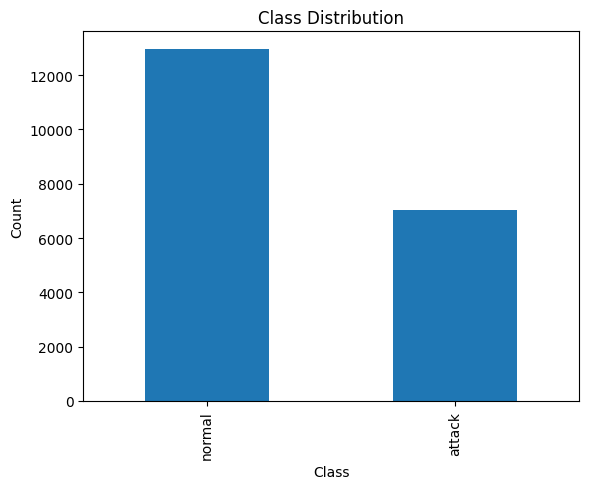

In [8]:
# 8. Attack vs Normal counts
class_counts = df['label'].value_counts().rename(index={0:'normal',1:'attack'})
print(class_counts)
class_counts.plot(kind='bar', title='Class Distribution'); plt.xlabel('Class'); plt.ylabel('Count'); plt.show()

In [9]:
# 9. Correlation with target (numeric features only)
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols_no_target = [c for c in numeric_cols if c != 'label']
corrs = df[numeric_cols_no_target + ['label']].corr(numeric_only=True)['label'].drop('label').sort_values(ascending=False)
print(corrs)

duration        0.605091
pkt_rate        0.526986
svc_latency     0.503468
urgent_pkts     0.407344
tcp_flags       0.347400
failed_login    0.182725
src_bytes       0.174028
dst_bytes       0.113748
Name: label, dtype: float64


In [10]:
# 10. Split features/target
X = df.drop(columns=['label'])
y = df['label']

# Identify column types
num_features = X.select_dtypes(include=[np.number]).columns.tolist()
cat_features = X.select_dtypes(exclude=[np.number]).columns.tolist()
num_features, cat_features

(['duration',
  'src_bytes',
  'dst_bytes',
  'pkt_rate',
  'tcp_flags',
  'failed_login',
  'urgent_pkts',
  'svc_latency'],
 ['protocol', 'service', 'state'])

In [11]:
# 11. Preprocessing: impute + scale numeric; impute + one-hot encode categorical
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features)
    ]
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y)
X_train.shape, X_test.shape

((15000, 11), (5000, 11))

In [12]:
# 12. Logistic Regression pipeline
logreg_clf = Pipeline(steps=[('prep', preprocessor),
                             ('model', LogisticRegression(max_iter=200, n_jobs=None))])
logreg_clf.fit(X_train, y_train)
y_pred_lr = logreg_clf.predict(X_test)
y_proba_lr = logreg_clf.predict_proba(X_test)[:,1]

print('LogReg Accuracy:', accuracy_score(y_test, y_pred_lr))
print('LogReg Precision:', precision_score(y_test, y_pred_lr))
print('LogReg Recall:', recall_score(y_test, y_pred_lr))
print('LogReg F1:', f1_score(y_test, y_pred_lr))
print('LogReg ROC-AUC:', roc_auc_score(y_test, y_proba_lr))

LogReg Accuracy: 0.9146
LogReg Precision: 0.8903225806451613
LogReg Recall: 0.863481228668942
LogReg F1: 0.8766965059197228
LogReg ROC-AUC: 0.9677947081079602


In [13]:
# 13. Random Forest pipeline
rf_clf = Pipeline(steps=[('prep', preprocessor),
                        ('model', RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1))])
rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)
y_proba_rf = rf_clf.predict_proba(X_test)[:,1]

print('RF Accuracy:', accuracy_score(y_test, y_pred_rf))
print('RF Precision:', precision_score(y_test, y_pred_rf))
print('RF Recall:', recall_score(y_test, y_pred_rf))
print('RF F1:', f1_score(y_test, y_pred_rf))
print('RF ROC-AUC:', roc_auc_score(y_test, y_proba_rf))

RF Accuracy: 0.9144
RF Precision: 0.8911764705882353
RF Recall: 0.8617747440273038
RF F1: 0.876229034123771
RF ROC-AUC: 0.9655870335240188


In [14]:
# 14. Gradient Boosting pipeline
gb_clf = Pipeline(steps=[('prep', preprocessor),
                        ('model', GradientBoostingClassifier(random_state=RANDOM_STATE))])
gb_clf.fit(X_train, y_train)
y_pred_gb = gb_clf.predict(X_test)
y_proba_gb = gb_clf.predict_proba(X_test)[:,1]

print('GB Accuracy:', accuracy_score(y_test, y_pred_gb))
print('GB Precision:', precision_score(y_test, y_pred_gb))
print('GB Recall:', recall_score(y_test, y_pred_gb))
print('GB F1:', f1_score(y_test, y_pred_gb))
print('GB ROC-AUC:', roc_auc_score(y_test, y_proba_gb))

GB Accuracy: 0.9142
GB Precision: 0.8865619546247818
GB Recall: 0.8668941979522184
GB F1: 0.8766177739430544
GB ROC-AUC: 0.9690816775554634


<Figure size 640x480 with 0 Axes>

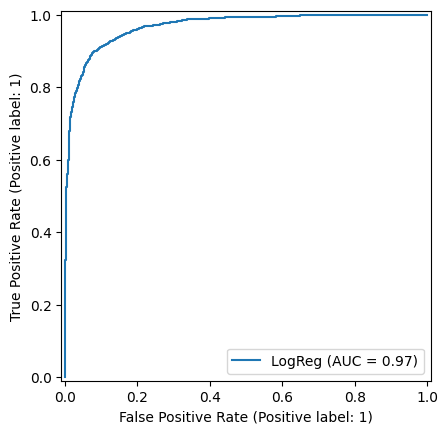

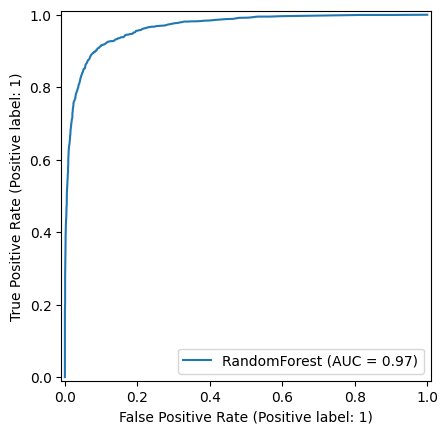

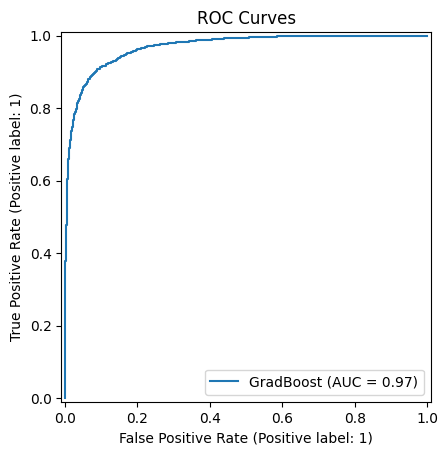

In [15]:
# 15. ROC curves comparison
plt.figure()
RocCurveDisplay.from_predictions(y_test, y_proba_lr, name='LogReg')
RocCurveDisplay.from_predictions(y_test, y_proba_rf, name='RandomForest')
RocCurveDisplay.from_predictions(y_test, y_proba_gb, name='GradBoost')
plt.title('ROC Curves')
plt.show()

In [16]:
# 16. Confusion matrices
for name, y_pred in [('LogReg', y_pred_lr), ('RandomForest', y_pred_rf), ('GradBoost', y_pred_gb)]:
    print(f'\n{name} Confusion Matrix')
    print(confusion_matrix(y_test, y_pred))


LogReg Confusion Matrix
[[3055  187]
 [ 240 1518]]

RandomForest Confusion Matrix
[[3057  185]
 [ 243 1515]]

GradBoost Confusion Matrix
[[3047  195]
 [ 234 1524]]


In [17]:
# 17. Classification reports
for name, y_pred in [('LogReg', y_pred_lr), ('RandomForest', y_pred_rf), ('GradBoost', y_pred_gb)]:
    print(f'\n{name} classification report')
    print(classification_report(y_test, y_pred, target_names=['normal','attack']))


LogReg classification report
              precision    recall  f1-score   support

      normal       0.93      0.94      0.93      3242
      attack       0.89      0.86      0.88      1758

    accuracy                           0.91      5000
   macro avg       0.91      0.90      0.91      5000
weighted avg       0.91      0.91      0.91      5000


RandomForest classification report
              precision    recall  f1-score   support

      normal       0.93      0.94      0.93      3242
      attack       0.89      0.86      0.88      1758

    accuracy                           0.91      5000
   macro avg       0.91      0.90      0.91      5000
weighted avg       0.91      0.91      0.91      5000


GradBoost classification report
              precision    recall  f1-score   support

      normal       0.93      0.94      0.93      3242
      attack       0.89      0.87      0.88      1758

    accuracy                           0.91      5000
   macro avg       0.91      

,0
duration,0.291164
pkt_rate,0.199595
svc_latency,0.176136
urgent_pkts,0.078931
tcp_flags,0.062523
src_bytes,0.062450
dst_bytes,0.047932
failed_login,0.011262
service_http,0.005766
state_S1,0.005542


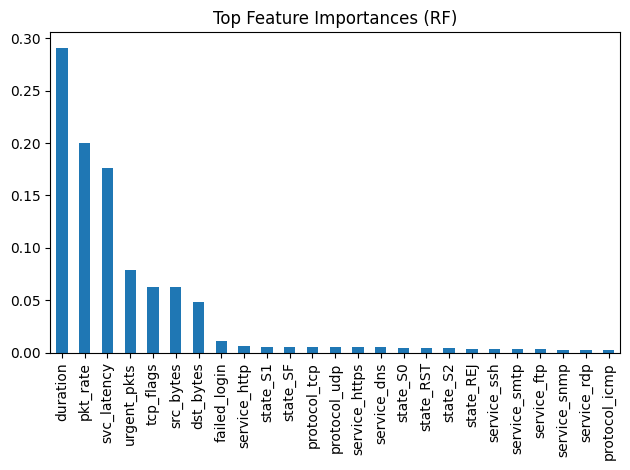

In [18]:
# 18. Feature importances from RandomForest
# Pull feature names from ColumnTransformer
ohe = rf_clf.named_steps['prep'].named_transformers_['cat'].named_steps['onehot']
cat_out = ohe.get_feature_names_out(rf_clf.named_steps['prep'].transformers_[1][2])

feature_names = list(num_features) + list(cat_out)
importances = rf_clf.named_steps['model'].feature_importances_
fi = pd.Series(importances, index=feature_names).sort_values(ascending=False)
display(fi.head(20))
fi.head(30).plot(kind='bar', title='Top Feature Importances (RF)'); plt.tight_layout(); plt.show()

,threshold,precision,recall,f1
0,0.10,0.609972,0.981229,0.752290
1,0.15,0.674990,0.968714,0.795609
2,0.20,0.717086,0.957338,0.819976
3,0.25,0.757104,0.939704,0.838579
4,0.30,0.799411,0.927190,0.858573
5,0.35,0.825486,0.917520,0.869073
6,0.40,0.852071,0.901024,0.875864
7,0.45,0.874224,0.881684,0.877938
8,0.50,0.888889,0.864619,0.876586
9,0.55,0.904966,0.839590,0.871053


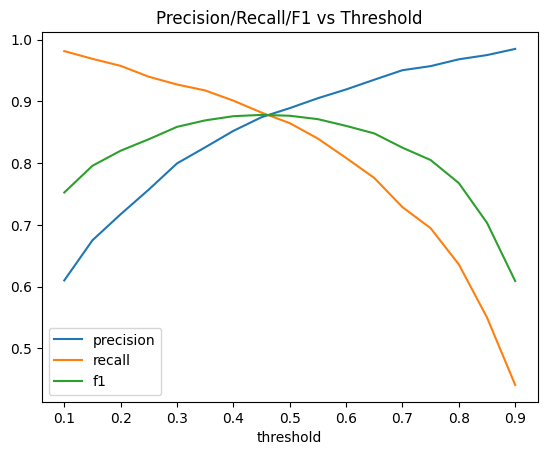

from matplotlib import pyplot as plt
df_thr['threshold'].plot(kind='hist', bins=20, title='threshold')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_thr['precision'].plot(kind='hist', bins=20, title='precision')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_thr['recall'].plot(kind='hist', bins=20, title='recall')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_thr['f1'].plot(kind='hist', bins=20, title='f1')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_thr.plot(kind='scatter', x='threshold', y='precision', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_thr.plot(kind='scatter', x='precision', y='recall', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_thr.plot(kind='scatter', x='recall', y='f1', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['threshold']
  ys = series['recall']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df_thr.sort_values('threshold', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('threshold')
_ = plt.ylabel('recall')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['threshold']
  ys = series['f1']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df_thr.sort_values('threshold', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('threshold')
_ = plt.ylabel('f1')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['threshold']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'threshold'}, axis=1)
              .sort_values('threshold', ascending=True))
  xs = counted['threshold']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df_thr.sort_values('threshold', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('threshold')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['precision']
  ys = series['recall']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df_thr.sort_values('precision', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('precision')
_ = plt.ylabel('recall')

from matplotlib import pyplot as plt
df_thr['threshold'].plot(kind='line', figsize=(8, 4), title='threshold')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df_thr['precision'].plot(kind='line', figsize=(8, 4), title='precision')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df_thr['recall'].plot(kind='line', figsize=(8, 4), title='recall')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df_thr['f1'].plot(kind='line', figsize=(8, 4), title='f1')
plt.gca().spines[['top', 'right']].set_visible(False)

In [19]:
# 19. Threshold tuning for RandomForest (optimize F1)
thresholds = np.linspace(0.1, 0.9, 17)
scores = []
for t in thresholds:
    pred_t = (y_proba_rf >= t).astype(int)
    scores.append((t, precision_score(y_test, pred_t), recall_score(y_test, pred_t), f1_score(y_test, pred_t)))

df_thr = pd.DataFrame(scores, columns=['threshold','precision','recall','f1'])
display(df_thr)
ax = df_thr.plot(x='threshold', y=['precision','recall','f1'], title='Precision/Recall/F1 vs Threshold')
plt.show()

In [20]:
# 20. Build a small ANN (on preprocessed numeric data)
# We'll reuse the preprocessor to transform X into numeric arrays, then train a Keras model.
from tensorflow import keras
from tensorflow.keras import layers

# Fit preprocessor on full training set and transform
X_train_np = preprocessor.fit_transform(X_train)
X_test_np = preprocessor.transform(X_test)

input_dim = X_train_np.shape[1]
model = keras.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy','AUC'])
history = model.fit(X_train_np, y_train, epochs=10, batch_size=256, validation_split=0.2, verbose=1)

Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - AUC: 0.7673 - accuracy: 0.7298 - loss: 0.5864 - val_AUC: 0.9633 - val_accuracy: 0.9103 - val_loss: 0.2792
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.9626 - accuracy: 0.9123 - loss: 0.2536 - val_AUC: 0.9706 - val_accuracy: 0.9177 - val_loss: 0.2072
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.9665 - accuracy: 0.9128 - loss: 0.2210 - val_AUC: 0.9717 - val_accuracy: 0.9197 - val_loss: 0.2033
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.9698 - accuracy: 0.9180 - loss: 0.2070 - val_AUC: 0.9723 - val_accuracy: 0.9200 - val_loss: 0.2013
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.9761 - accuracy: 0.9270 - loss: 0.1868 - val_AUC: 0.9729 - val_accuracy: 0.9180 - val_loss: 0.1996
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.9734 - accuracy: 0.9235 - loss: 0.1963 - val_AUC: 0.9732 - val_accuracy: 0.9217 - val_loss: 0.1982
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step -

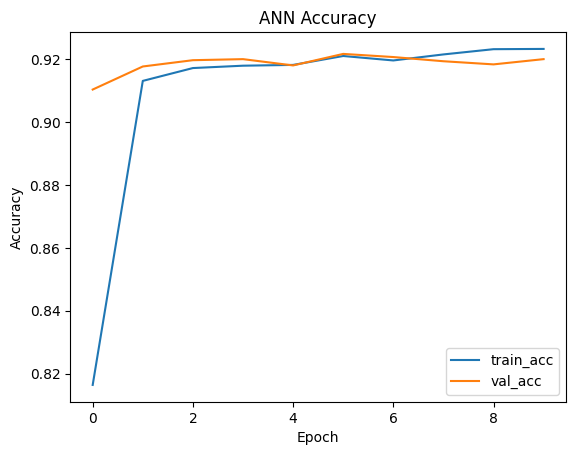

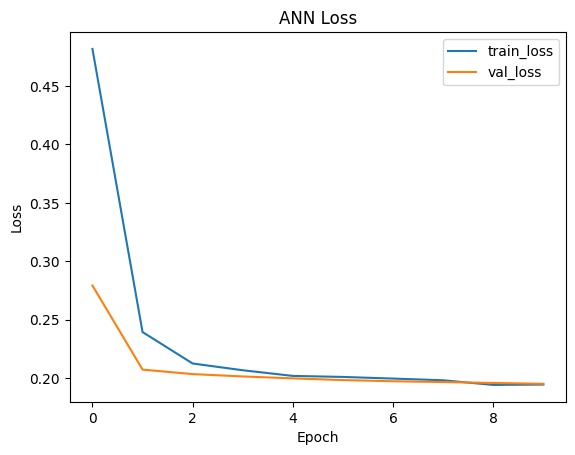

In [21]:
# 21. Plot ANN training curves
plt.figure()
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('ANN Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.show()

plt.figure()
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('ANN Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.show()

In [22]:
# 22. Evaluate ANN on test set
ann_metrics = model.evaluate(X_test_np, y_test, verbose=0)
y_proba_ann = model.predict(X_test_np, verbose=0).ravel()
y_pred_ann = (y_proba_ann >= 0.5).astype(int)

print('ANN Test Accuracy:', accuracy_score(y_test, y_pred_ann))
print('ANN Precision:', precision_score(y_test, y_pred_ann))
print('ANN Recall:', recall_score(y_test, y_pred_ann))
print('ANN F1:', f1_score(y_test, y_pred_ann))
print('ANN ROC-AUC:', roc_auc_score(y_test, y_proba_ann))

ANN Test Accuracy: 0.9184
ANN Precision: 0.89198606271777
ANN Recall: 0.8737201365187713
ANN F1: 0.8827586206896552
ANN ROC-AUC: 0.9707892149328461


<Figure size 640x480 with 0 Axes>

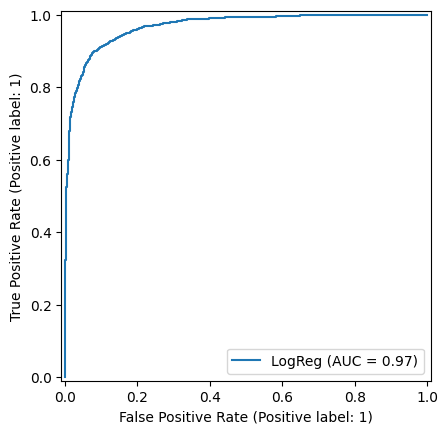

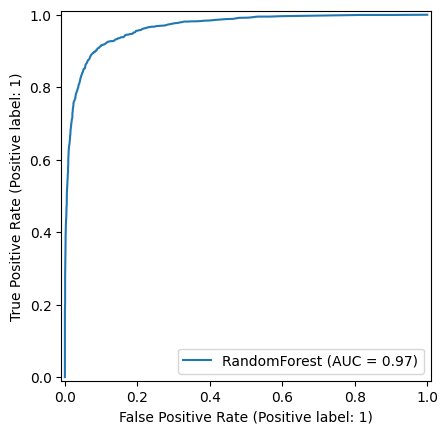

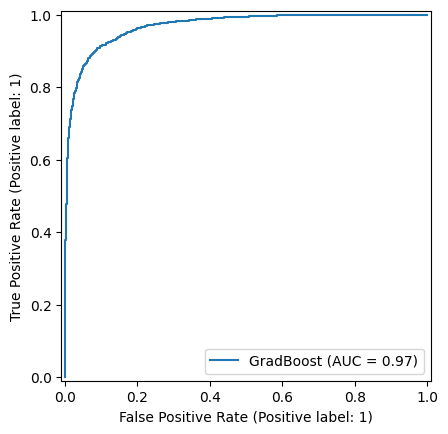

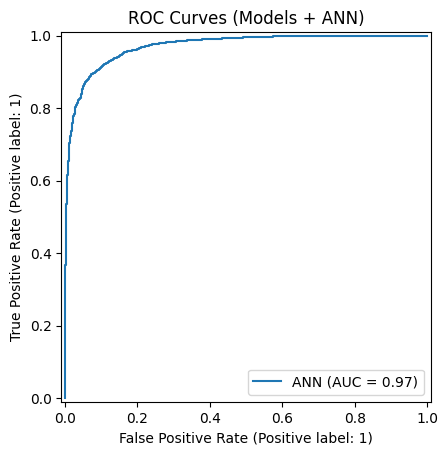

In [23]:
# 23. ROC comparison including ANN
plt.figure()
RocCurveDisplay.from_predictions(y_test, y_proba_lr, name='LogReg')
RocCurveDisplay.from_predictions(y_test, y_proba_rf, name='RandomForest')
RocCurveDisplay.from_predictions(y_test, y_proba_gb, name='GradBoost')
RocCurveDisplay.from_predictions(y_test, y_proba_ann, name='ANN')
plt.title('ROC Curves (Models + ANN)')
plt.show()

In [24]:
# 24. Create a few synthetic new 'flows' to predict
new_samples = pd.DataFrame({
    'duration': [1.2, 8.4],
    'src_bytes': [11000, 500000],
    'dst_bytes': [8000, 120000],
    'pkt_rate': [180, 320],
    'tcp_flags': [2, 4],
    'failed_login': [0, 1],
    'urgent_pkts': [0, 2],
    'svc_latency': [90, 180],
    'protocol': ['tcp', 'udp'],
    'service': ['http', 'ssh'],
    'state': ['SF', 'S0']
})
display(new_samples)

# Use the best classical model (replace with your preferred model)
best_model = rf_clf
proba = best_model.predict_proba(new_samples)[:,1]
pred = (proba >= 0.5).astype(int)
pd.DataFrame({'attack_prob': proba, 'pred_label': pred})

,duration,src_bytes,dst_bytes,pkt_rate,tcp_flags,failed_login,urgent_pkts,svc_latency,protocol,service,state
0,1.2,11000,8000,180,2,0,0,90,tcp,http,SF
1,8.4,500000,120000,320,4,1,2,180,udp,ssh,S0


,attack_prob,pred_label
0,0.020,0
1,0.975,1


from matplotlib import pyplot as plt
_df_11['attack_prob'].plot(kind='hist', bins=20, title='attack_prob')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_12['pred_label'].plot(kind='hist', bins=20, title='pred_label')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_13.plot(kind='scatter', x='attack_prob', y='pred_label', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['attack_prob']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'attack_prob'}, axis=1)
              .sort_values('attack_prob', ascending=True))
  xs = counted['attack_prob']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_14.sort_values('attack_prob', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('attack_prob')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['pred_label']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'pred_label'}, axis=1)
              .sort_values('pred_label', ascending=True))
  xs = counted['pred_label']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_15.sort_values('pred_label', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('pred_label')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_16['attack_prob'].plot(kind='line', figsize=(8, 4), title='attack_prob')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_17['pred_label'].plot(kind='line', figsize=(8, 4), title='pred_label')
plt.gca().spines[['top', 'right']].set_visible(False)

In [25]:
# 25. IsolationForest on preprocessed features (no labels needed)
iso_pipe = Pipeline(steps=[('prep', preprocessor),
                          ('model', IsolationForest(random_state=RANDOM_STATE, contamination=0.15))])
iso_pipe.fit(X_train)
anomaly_scores = iso_pipe.named_steps['model'].score_samples(iso_pipe.named_steps['prep'].transform(X_test))
anomaly_pred = iso_pipe.named_steps['model'].predict(iso_pipe.named_steps['prep'].transform(X_test))  # -1 anomaly, 1 normal

unique, counts = np.unique(anomaly_pred, return_counts=True)
print(dict(zip(unique, counts)))

{np.int64(-1): np.int64(771), np.int64(1): np.int64(4229)}


In [26]:
# 26. Save RandomForest pipeline as joblib
OUT_DIR = Path('artifacts')
OUT_DIR.mkdir(exist_ok=True)
model_path = OUT_DIR / 'rf_threat_model.joblib'
joblib.dump(rf_clf, model_path)
print('Saved to:', model_path)

Saved to: artifacts/rf_threat_model.joblib


In [27]:
# 27. Load back and re-evaluate
loaded = joblib.load(model_path)
y_pred_loaded = loaded.predict(X_test)
print('Loaded model F1:', f1_score(y_test, y_pred_loaded))

Loaded model F1: 0.876229034123771


In [28]:
# 28. (Optional) Save preprocessor and ANN separately for production
prep_path = OUT_DIR / 'preprocessor.joblib'
ann_path = OUT_DIR / 'ann_threat_model.keras'  # Keras native format
joblib.dump(preprocessor, prep_path)
model.save(ann_path)
print('Saved preprocessor to:', prep_path)
print('Saved ANN to:', ann_path)

Saved preprocessor to: artifacts/preprocessor.joblib
Saved ANN to: artifacts/ann_threat_model.keras


In [29]:
# 29. Helper function to score a dataframe with the loaded RF pipeline
def score_flows(df_flows, model):
    proba = model.predict_proba(df_flows)[:,1]
    pred = (proba >= 0.5).astype(int)
    return pd.DataFrame({'attack_prob': proba, 'pred_label': pred})

# Demo with earlier new_samples
score_flows(new_samples, loaded)

,attack_prob,pred_label
0,0.020,0
1,0.975,1


from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['attack_prob'].plot(kind='hist', bins=20, title='attack_prob')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['pred_label'].plot(kind='hist', bins=20, title='pred_label')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3.plot(kind='scatter', x='index', y='attack_prob', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='attack_prob', y='pred_label', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_5.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['attack_prob']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'attack_prob'}, axis=1)
              .sort_values('attack_prob', ascending=True))
  xs = counted['attack_prob']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_6.sort_values('attack_prob', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('attack_prob')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['pred_label']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'pred_label'}, axis=1)
              .sort_values('pred_label', ascending=True))
  xs = counted['pred_label']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_7.sort_values('pred_label', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('pred_label')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_8['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_9['attack_prob'].plot(kind='line', figsize=(8, 4), title='attack_prob')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_10['pred_label'].plot(kind='line', figsize=(8, 4), title='pred_label')
plt.gca().spines[['top', 'right']].set_visible(False)